# Lyrics Classification Project

### Step 1. Importing libraries

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation

import spacy 
nlp = spacy.load('en_core_web_sm')

### Step 2. To scrape the lyrics use lyrics_scraper.py to save lyrics as csv files

In [2]:
ETTA = 'Etta'
BILLY = 'Billy'

### Step 3. Extracting clean text from lyrics

In [24]:
def lyrics_cleaner(lyrics):
    """ Clean html leftovers with regex """
    lyrics_clean = []
    for i in lyrics:
        text = re.sub('\r|\s+|\(|\)|\[|\]|\,|\?|\!|\-|\"|\:|\;|\.|\“|\"|\”|CHORUS', ' ', i)
        lyrics_clean.append(text)
    word_end = []
    for j in lyrics_clean:
        text2 = re.sub('''(?:_a)?in'\s''', 'ing ', j)
        word_end.append(text2)
    return word_end

def import_data(first_name):
    """ Import csv, clean lyrics syntax, drop duplicates, convert back to list """
    l = lyrics_cleaner(pd.read_csv(f'{first_name}_cleaned.csv')['0'].tolist())
    return l

def drop_duplicates(spacyfied_lyr):
    """ Take first 6 words of the lyrics, add as new column, drop duplicate rows, join back to original df """
    splitted_text =[]
    joined_back= []
    df = pd.DataFrame(spacyfied_lyr)
    for i in spacyfied_lyr:
        splitted = i.lower().split()
        first_six = splitted[0:6]
        splitted_text.append(first_six)
    for j in splitted_text:
        joined = ' '.join(j)
        joined_back.append(joined)
    drop_dup = pd.DataFrame(joined_back).drop_duplicates()
    merged = pd.merge(df, drop_dup, how='inner', left_index=True, right_index=True).iloc[:,0].to_list()
    return merged

In [4]:
etta_lyr = drop_duplicates(import_data(ETTA))
del etta_lyr[176], etta_lyr[91]  # Unclean data on lyrics.com: Gucci Mane song instead of Etta's song -> del
billy_lyr = drop_duplicates(import_data(BILLY))

### Step 4. Balancing classes

In [5]:
print (f'''Number of Etta James' songs: {len(etta_lyr)}
Number of Billy Joel's songs: {len(billy_lyr)}''')

Number of Etta James' songs: 224
Number of Billy Joel's songs: 151


In [6]:
random.seed(10)
index = random.sample(range(len(etta_lyr)), len(etta_lyr)-len(billy_lyr))

def dropped_songs(etta_lyr):
    """ Keep dropped songs to use later for model evaluation """
    etta_dropped = []
    for i in index:
        song = etta_lyr[i]
        etta_dropped.append(song)
    return etta_dropped 

def random_delete(song_lyr):
    """ Deletes randomly selected songs to even the classes """
    for i in sorted(index, reverse=True):
        del song_lyr[i] 
    return song_lyr

In [7]:
etta_dropped = dropped_songs(etta_lyr)
etta_lyr = random_delete(etta_lyr)
lyrics = etta_lyr + billy_lyr

## Natural Language Processing

### Step 6. Token preprocessing with Spacy 

In [8]:
def spacify_my_text(lyrics_text):
    """ Use Spacy to lowercae all characters, lemmatize words and remove stop words """
    spacyfied = []
    for sentence in lyrics_text:
        parsed_sentence = nlp(sentence.lower())
        treated_sentence = ''
        for token in parsed_sentence:
            if not token.is_stop:
                treated_sentence += str(token.lemma_) + ' '
        spacyfied.append(treated_sentence.strip())
    return spacyfied

lyr_spacy = spacify_my_text(lyrics)

### Step 7. Train test split

In [9]:
X = pd.Series(lyr_spacy)
y = [ETTA] * len(etta_lyr) + [BILLY] * len(billy_lyr)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Step 8. Converting text into a numerical matrix with Bag of Words and using Multinominal Naive Bayes classifier to train the data

In [10]:
def cv_tf():
    """ Convert text to matrix of token counts, normalize the representation of the matrix """
    cv = CountVectorizer(min_df=5)
    tf = TfidfTransformer()
    return cv, tf

def fit_transform_X(X_input):
    """ Count Vectorizer converts vector into a matrix, TD-IDF normalizes the matrix """
    X_vec = cv.fit_transform(X_input)
    X_tf = tf.fit_transform(X_vec)
    return X_tf

def transform_X(X_input):
    """ Transform vector to matrix, according to training fit_transform """
    X_vec = cv.transform(X_input)
    X_tf = tf.transform(X_vec)
    return X_tf

def naive_bayes(X_tf, y_train):
    """ Count Vectorizer and TD-IDF """
    m = MultinomialNB()
    m.fit(X_tf, y_train)
    return m

def model_score(X, y, model):
    """ Calculates the training and validation accuracy """
    score = model.score(X, y).round(4)
    val_acc = cross_val_score(model, X, y, cv=5).round(4)
    return score, val_acc    

In [11]:
cv, tf = cv_tf()
X_train_tf = fit_transform_X(X_train)
model = naive_bayes(X_train_tf, y_train) 
score_train, val_acc_train = model_score(X_train_tf, y_train, model)

In [12]:
X_test_tf = transform_X(X_test)
score_test, val_acc_test = model_score(X_test_tf, y_test, model)

In [13]:
print(f'Training accuracy: {score_train}')
print(f'Training cross-validation accuracy mean: {val_acc_train.mean().round(4)}')
print(f'Test accuracy: {score_test}')
print(f'Test cross-validation accuracy mean: {val_acc_test.mean().round(4)}')

Training accuracy: 0.9602
Training cross-validation accuracy mean: 0.8051
Test accuracy: 0.75
Test cross-validation accuracy mean: 0.6317


### Step 9. Word occurence mapping 
More insigihts from the analysis -> which words are likely to belong to which artist

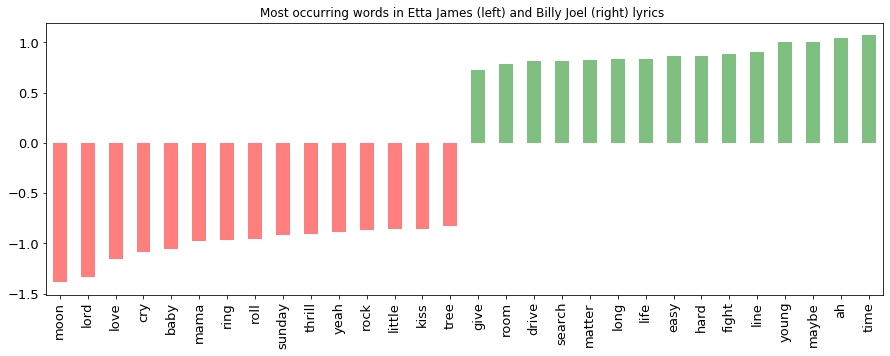

In [14]:
def word_occurence():
    """ Creates table of most occurring words using log probabilities of features """
    feature_log_probs = model.feature_log_prob_
    diff = feature_log_probs[0]-feature_log_probs[1]
    likelyhood = pd.DataFrame(data=diff, index = sorted(cv.vocabulary_.keys())
                             ).sort_values(by=0).rename({0: ' '}, axis = 1)
    head = likelyhood.head(15)
    tail = likelyhood.tail(15)
    important_words = pd.concat([head, tail])
    fig = important_words.plot(kind='bar', 
                           figsize=(15,5), 
                           fontsize=13, 
                           legend=None, 
                           color=[np.where(important_words.iloc[:,0]>0, 'g', 'r')], 
                           alpha=0.5)
    plt.title('Most occurring words in Etta James (left) and Billy Joel (right) lyrics ')
    return fig 

word_occurence()

### Step 10. Testing the model on 73 Etta James songs that were taken out to balance the classes

<BarContainer object of 2 artists>

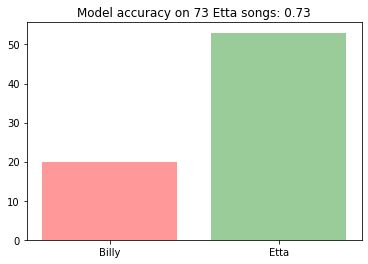

In [15]:
def prediction_tester(etta_dropped):
    """ Predicts lyrics for Etta James songs """
    etta_tf = transform_X(spacify_my_text(etta_dropped))
    y_true = len(etta_dropped) * [ETTA]
    score = model.score(etta_tf, y_true).round(2)
    prediction = model.predict(etta_tf)
    unique, counts = np.unique(prediction, return_counts=True)
    fig2 = plt.bar(unique, counts, color=('r', 'g'), alpha = 0.4)
    plt.title(f'Model accuracy on 73 Etta songs: {score}')
    return fig2
prediction_tester(etta_dropped)                            

### Potential for improvement
Billy Joel has more unique words per song -> balance lyrics distribution 

In [16]:
def lyrics_distribution(lyrics, colname):
    df = pd.DataFrame(lyrics, columns=[colname])
    df_cleanup = df[colname].str.lower().str.split()
    df['LyricsCounter'] = df_cleanup.apply(set).apply(len)
    return df

In [17]:
billy_df = lyrics_distribution(billy_lyr, BILLY)
etta_df = lyrics_distribution(etta_lyr, ETTA)

Text(0.5, 1.0, 'Lyrics length distribution - Etta (red), Billy (blue)')

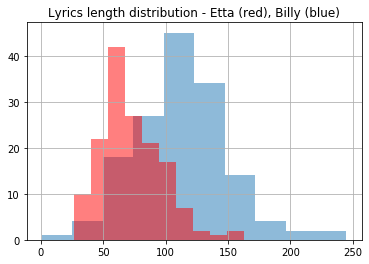

In [18]:
billy_df['LyricsCounter'].hist(alpha=0.5)
etta_df['LyricsCounter'].hist(color='r', alpha=0.5)
plt.title('Lyrics length distribution - Etta (red), Billy (blue)')